In [2]:
from torchvision import transforms, models 
import torch
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk #return max element in dim (can return K-max elements)
import numpy as np
import skimage.transform
from torchvision.models import resnet50, ResNet50_Weights

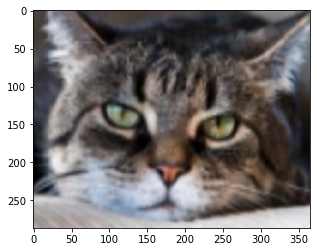

In [79]:

#Загружаем свое изображение
image = Image.open("cat.jpg")
imshow(image)


In [80]:
# Препроцессим и нормализуем дату
norm_data = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
norm_data

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [81]:
import re
with open('imagenet1000.txt') as f:
    temp = f.readlines()
    f.close()
labels = list(range(len(temp)))
for i, str in enumerate(temp):
    labels[i] = set(re.findall(r'[A-Za-z]+', str))


In [82]:

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   norm_data
])
preprocess

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [83]:

display = transforms.Compose([transforms.Resize((224,224))])
tensor_preprocess = preprocess(image)
pred = Variable((tensor_preprocess.unsqueeze(0)), requires_grad=False) #add one dimention at start of tensor

tensor_preprocess.shape #3 224 224 tensor with number
pred.shape


torch.Size([1, 3, 224, 224])

In [1]:
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()
print()

NameError: name 'models' is not defined

In [85]:
#Класс Hook можно подсмотреть в реализации fast.ai
class Hook(): # The hook will be called every time after forward() has computed an output
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

In [86]:
#Получаем карты активации с последнего сверточного слоя
final_layer = model._modules.get('layer4')
act_maps = Hook(final_layer)


In [87]:

#Прогоняем нашу картинку через модель и затем удаляем hook, дабы избежать утечки памяти
prediction = model(pred) # 1 3 224 224
print(prediction.shape) # 1 1000
pred_prob = F.softmax(prediction, -1).data.squeeze()
# act_maps.remove()

max(pred_prob) # 1000 class -> len 1000 output from softmax

torch.Size([1, 1000])


tensor(0.6571)

model weigth size:  2
imp (7, 7)


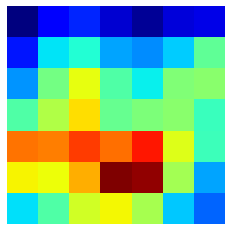

In [88]:
#Оцениваем какой вклад сделали наши карты признаков
def CAM(out_feature_conv, sum_weight, idx):
#     print('out_feature:', out_feature_conv.shape)
    
    _, nc, h, w = out_feature_conv.shape #1 2048 7 7
    
#     print('number of channel: ', nc) # 2048
#     idx is max value present in index form in pred_prob. 1000 classes

#     print('sum weight in index - idx', sum_weight[idx]) # 2048
    
#     print('out_feature with reshape: ',
#           out_feature_conv.reshape((nc, h*w)).shape) # 2048 7*7=49
    
    imp = sum_weight[idx].dot(out_feature_conv.reshape((nc, h*w)))\
                         .reshape(h, w) # return to 7 X 7
    
    print('imp', imp.shape)
    
    cam = imp - np.min(imp)
    cam = cam / np.max(cam)
    return [cam]
    
weight_softmax_params = list(model._modules.get('fc').parameters())

# print('model get fc', weight_softmax_params[0].shape, #1000 X 2048
#                       weight_softmax_params[1].shape) #[1000]

#   prediction = model(pred) # 1 3 224 224
#   pred_prob = F.softmax(prediction, -1).data.squeeze()

print('model weigth size: ', len(weight_softmax_params))

weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
idx = topk(pred_prob,1)[1].int() #281

# topk(pred_prob,1)              #index = 281 value = 0.6571
# act_maps.features.shape        #act_maps 1 2048 7 7
overlay = CAM(act_maps.features, weight_softmax, idx)
# print('overlay has len: ', len(overlay), overlay[0].shape) # 7 7  len=1
plt.axis('off')
imshow(overlay[0], alpha=1, cmap='jet')



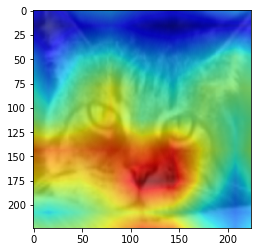

In [89]:
imshow(display(image))
# plt.axis('off')
imshow(skimage.transform.resize(overlay[0], tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')

In [90]:
import math

#CAM for last layers FC-layer

def CAM(out_feature_conv, sum_weight, idx, number_of_pic):
#     number of channel, nc # 2048
#     idx is max value present in index form in pred_prob. 1000 classes
   
#     out_feature with reshape: 
#           out_feature_conv.reshape((nc, h*w)).shape) # 2048 7*7=49

#     sum_weight[idx=281].dot(out_feature_conv.reshape((nc, h*w)))\
#                          .reshape(h, w) # return to 7 X 7
   
        
    _, nc, h, w = out_feature_conv.shape #1 2048 7 7
    imp = np.zeros([number_of_pic, h, w])
    imp[:,:,:] = [sum_weight[i+idx]\
                        .dot(out_feature_conv.reshape((nc, h*w)))\
                        .reshape(h, w) for i in range(number_of_pic)]
    
    cam = imp - np.min(imp)
    cam = cam / np.max(cam)
    
    return [cam]   

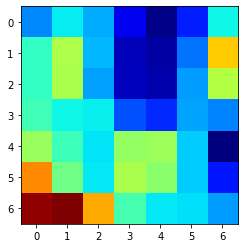

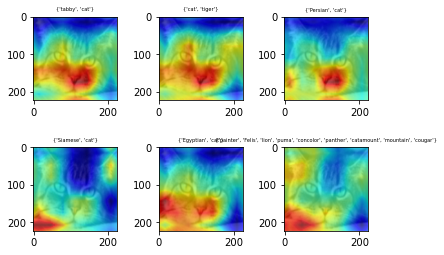

In [91]:
#print('model get fc: ', weight_softmax_params[0].shape, #1000 X 2048
#                       weight_softmax_params[1].shape) #[1000]
#print('model weigth size: ', len(weight_softmax_params)) # 2
#prediction = model(pred) # 1 3 224 224
#pred_prob = F.softmax(prediction, -1).data.squeeze()
#print('topk', topk(pred_prob,1)) # index = 281 value = 0.6571
#print('act_maps', act_maps.features.shape) #act_maps 1 2048 7 7

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
idx = topk(pred_prob,1)[1].int() #281
overlay = CAM(act_maps.features, weight_softmax, idx, 6)
# number of pics - overlay[0].shape: 6 pic, pic's size 7x7
# print(tensor.shape[1:3]) #224 224
imshow(overlay[0][3], alpha=1, cmap='jet')

row = 2
col = math.ceil(len(overlay[0][0])/row)-1
f, ax = plt.subplots(row, col)
f.subplots_adjust(wspace=0.5, hspace=0.5)
x = (col)*[0]

for i in range(len(range(row))):
    for j in range(col):
        if i == 1: 
            x = col*[int(col)]
        ax[i][j].imshow(display(image))
        ax[i][j].set_title(labels[281+j+x[j]], fontsize=5)    
        ax[i][j].imshow(skimage.transform.resize(overlay[0][j+x[j]], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')

In [113]:
# layer_three = model._modules.get('layer3')
# for name , param in layer_three.named_parameters():
#     print('name:', name, 'param:', param.size())

# print('LAYER FOUR')
# layer_four = model._modules.get('layer4')
# for name , param in layer_four.named_parameters():
#     print('name:', name, '\tparam:', param.size())
    
# print('FC')
# fc = model._modules.get('fc')  
# for name , param in fc.named_parameters():
#     print('name:', name, '\tparam:', param.size())

# print('LAYER FOUR - GET MODULES')
layer_four = model._modules.get('layer1')
for name , param in layer_four.named_modules():
    print('name:', name, '\tparam:', param)
    

name:  	param: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Co

In [93]:
#Класс Hook можно подсмотреть в реализации fast.ai
class Hook(): # The hook will be called every time after forward() has computed an output
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()

layer = model._modules.get('layer3')
act = Hook(layer)

prediction = model(pred) # 1 3 224 224
print(act.features.shape)
# pred_prob = F.softmax(prediction, -1).data.squeeze()



(1, 1024, 14, 14)


In [101]:
weight = model._modules.get('layer3').get_submodule('5').get_submodule('bn3')
w_bn3_one = list(weight.parameters())[0]
w_bn3_two = list(weight.parameters())[1]
print(w_bn3_one.shape)

torch.Size([1024])


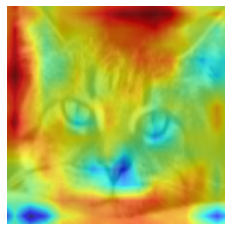

In [95]:
def CAM(out_feature_conv, sum_weight, idx):
#     print('out_feature:', out_feature_conv.shape)
    
    _, nc, h, w = out_feature_conv.shape #1 2048 7 7
    
#     print('number of channel: ', nc) # 2048
#     idx is max value present in index form in pred_prob. 1000 classes

#     print('sum weight in index - idx', sum_weight[idx]) # 2048
    
#     print('out_feature with reshape: ',
#           out_feature_conv.reshape((nc, h*w)).shape) # 2048 7*7=49
    
    imp = sum_weight.dot(out_feature_conv.reshape((nc, h*w)))\
                         .reshape(h, w) # return to 7 X 7
    
    cam = imp - np.min(imp)
    cam = cam / np.max(cam)
    return [cam]
    

# print('model get fc', weight_softmax_params[0].shape, #1000 X 2048
#                       weight_softmax_params[1].shape) #[1000]

#   prediction = model(pred) # 1 3 224 224
#   pred_prob = F.softmax(prediction, -1).data.squeeze()


weights = np.squeeze(w_bn3_one.cpu().data.numpy())
weights = np.squeeze(w_bn3_two.cpu().data.numpy())
# print(weights)
idx = topk(pred_prob,1)[1].int() #281

overlay = CAM(act.features, weights, idx)
plt.axis('off')
# imshow(overlay[0], alpha=1, cmap='jet')
imshow(display(image))

imshow(skimage.transform.resize(overlay[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')


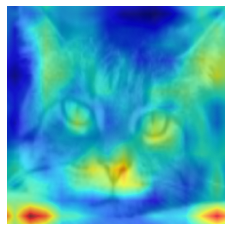

In [96]:
weights_two = np.squeeze(w_bn3_one.cpu().data.numpy())
# print(weights)
idx = topk(pred_prob,1)[1].int() #281

overlay_two = CAM(act.features, weights_two, idx)
plt.axis('off')
# imshow(overlay[0], alpha=1, cmap='jet')
imshow(display(image))

imshow(skimage.transform.resize(overlay_two[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')

In [107]:
#Класс Hook можно подсмотреть в реализации fast.ai
class Hook(): # The hook will be called every time after forward() has computed an output
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()

layer_two = model._modules.get('layer2')
act_two = Hook(layer_two)

prediction = model(pred) # 1 3 224 224
print(act_two.features.shape)
# pred_prob = F.softmax(prediction, -1).data.squeeze()

weight = model._modules.get('layer2').get_submodule('3').get_submodule('bn3')
w_bn3_layer_two_one = list(weight.parameters())[0]
w_bn3_layer_two_two = list(weight.parameters())[1]
print(w_bn3_layer_two_one.shape)

(1, 512, 28, 28)
torch.Size([512])


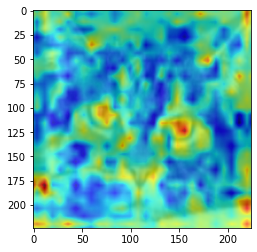

In [109]:
weights_layer_two_one = np.squeeze(w_bn3_layer_two_one.cpu().data.numpy())
weights_layer_two_two = np.squeeze(w_bn3_layer_two_two.cpu().data.numpy())
# print(weights)
idx = topk(pred_prob,1)[1].int() #281

overlay = CAM(act_two.features, weights_layer_two_one, idx)
imshow(display(image))
imshow(skimage.transform.resize(overlay[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')


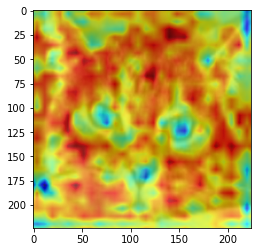

In [110]:
weights_layer_two_one = np.squeeze(w_bn3_layer_two_one.cpu().data.numpy())
weights_layer_two_two = np.squeeze(w_bn3_layer_two_two.cpu().data.numpy())

idx = topk(pred_prob,1)[1].int() #281

overlay = CAM(act_two.features, weights_layer_two_two, idx)
imshow(display(image))
imshow(skimage.transform.resize(overlay[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')


In [135]:
#Класс Hook можно подсмотреть в реализации fast.ai
class Hook(): # The hook will be called every time after forward() has computed an output
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()

layer_one = model._modules.get('layer1')
act_one = Hook(layer_one)

prediction = model(pred) # 1 3 224 224
print(act_one.features.shape)
# pred_prob = F.softmax(prediction, -1).data.squeeze()

weight = model._modules.get('layer1').get_submodule('2').get_submodule('bn3')
w_bn3_layer_one_one = list(weight.parameters())[0]
w_bn3_layer_one_two = list(weight.parameters())[1]
print(w_bn3_layer_one_one.shape)

(1, 256, 56, 56)
torch.Size([256])


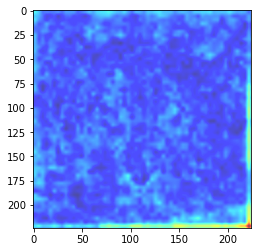

In [136]:
w_bn3_layer_one_one = np.squeeze(w_bn3_layer_one_one.cpu().data.numpy())
# print(weights)
idx = topk(pred_prob,1)[1].int() #281

overlay = CAM(act_one.features, w_bn3_layer_one_one, idx)
# imshow(display(image))
imshow(skimage.transform.resize(overlay[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')


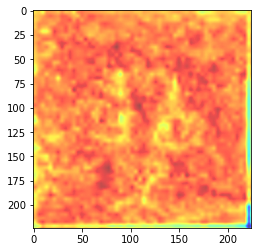

In [133]:
w_bn3_layer_one_two = np.squeeze(w_bn3_layer_one_two.cpu().data.numpy())
# print(weights)
idx = topk(pred_prob,1)[1].int() #281

overlay = CAM(act_one.features, w_bn3_layer_one_two, idx)
# imshow(display(image))
imshow(skimage.transform.resize(overlay[0], 
                             tensor_preprocess.shape[1:3]), alpha=0.7, cmap='jet')


In [154]:
#Vector distance calculation. Features from features, based on CAM 
class Hook(): 
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()

layer_one = model._modules.get('layer4')
act_one = Hook(layer_one)

prediction = model(pred) # 1 3 224 224

def vector_cam_by_idx(out_feature_conv, sum_weight, idx):
    _, nc, h, w = out_feature_conv.shape #1 2048 7 7
    imp = sum_weight[idx].dot(out_feature_conv.reshape((nc, h*w)))
    print(imp)
    cam = imp - np.min(imp)
    cam = cam / np.max(cam)
    return cam

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
idx = topk(pred_prob,1)[1].int() #281
vector = vector_cam_by_idx(act_maps.features, weight_softmax, idx)

print(overlay.shape)



[ 2.9025183  5.676621   6.7907596  4.6168637  3.4480693  4.772086
  5.04137    6.3512793 11.258339  12.248092   9.771144   9.208984
 10.703136  14.02914    9.381349  14.537087  17.93545   13.545254
 11.521943  14.9041195 15.193329  13.58181   16.328074  18.9727
 14.1918745 14.824436  15.210113  12.857363  21.635206  21.325827
 23.016247  21.693157  23.919708  17.647268  12.952701  18.40893
 18.09237   20.161312  26.699202  26.294418  15.972497   9.729073
 11.121668  13.504015  17.27537   18.305405  16.079485  10.55557
  8.250608 ]
(49,)


In [123]:
#Understanding of the Pytorch_hook
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        out = F.relu(self.conv1(x))     #1 
        out = F.max_pool2d(out, 2)      #2
        out = F.relu(self.conv2(out))   #3
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
features = []
def hook(module, input, output): 
    # module: model.conv2 
    # input :in forward function  [#2]
    # output:is  [#3 self.conv2(out)]
    features.append(output.clone().detach())
    # output is saved  in a list 
 
 
net = LeNet() ## Model instantiation 
x = torch.randn(2, 3, 32, 32) ## input 
handle = net.conv2.register_forward_hook(hook) ## Get the intermediate result of the entire Lenet model conv2
y = net(x) ## Get the result of conv2 about input x 
 
print(features[0].size()) # ie [#3 self.conv2(out)]
handle.remove()

torch.Size([2, 16, 10, 10])


In [52]:
from torch import nn

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1) # change dimention from 1 X n to n X 1

In [ ]:
model_G = models.resnet50()
model_G.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model_G.eval()

# print(list(model_G.children())[:-1])
# print([Flatten()])
# x = torch.tensor([1.1,3,4])
# print(x)
# print(x.size())
# print(x.view(x.size(0), -1))


In [ ]:
(list(model_G.children())[-2:-1] + [Flatten] + list(model_G.children())[-1:])

sizes = [1,32,64]
for in_f, out_f in zip(sizes, sizes[1:]):
    
    print(in_f, out_f)

In [ ]:
f_ex = nn.Sequential(*list(model_G.children())[:-2]) #without last element
classification = nn.Sequential(*(list(model_G.children())[-2:-1] #pre last element
                                 + [Flatten()] 
                                 + list(model_G.children())[-1:]))#in reverse order    


def GradCAM(img, cl_sc, f_ex, classification):
    f_map = f_ex(img)
    print(f_map.shape)
    _, N, H, W = f_map.size()
    print('classification: ', classification(f_map).shape)
    c_score = classification(f_map)[0,cl_sc]
    print('c_score: ', c_score)
    grads = torch.autograd.grad(c_score, f_map) #Computes and returns the sum of gradients of outputs with respect to the inputs. 
    print(grads[0][0].shape)
    print(grads[0][0].mean(-1).shape)
    print(grads[0][0].mean(-1).mean(-1).shape)
    w = grads[0][0].mean(-1).mean(-1)
    gradcam = torch.matmul(w, f_map.view(N, H*W))
    gradcam = gradcam.view(H, W).cpu().detach().numpy()
    gradcam = np.maximum(gradcam, 0)
    
    return gradcam

In [ ]:
prob, class_cl = torch.topk(nn.Softmax(dim=1)(model_G(pred)), 3) #Returns the k largest elements of the given input tensor along a given dimension.
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
print('pred:', pred.shape)
gradcam = GradCAM(pred, int(class_cl[0][0]), f_ex, classification)
gradcam = Image.fromarray(gradcam)
gradcam = gradcam.resize(image.size, resample=Image.LINEAR)

#Plot our mask
plt.axis('off')
plt.imshow(np.array(gradcam), alpha=0.5, cmap='jet')

plt.imshow(image)
plt.axis('off')
plt.imshow(np.array(gradcam), alpha=0.5, cmap='jet')
plt.show()

In [ ]:
test_model = models.resnet50()
test_model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
test_model.eval()

def prep_output(img_tensor):
    out = norm_data(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)
    print('prep_output: ', out)
    return out


In [ ]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        print('relu_hook_function OK')
        return (torch.clamp(grad_in[0], min=0.),)


In [ ]:
for i, module in enumerate(test_model.modules()):
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

In [ ]:

def norm_flat_image(img):
    grads_norm = prep_output(img)
    print('grads_norm: ', grads_norm[:, :, 0])
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

In [ ]:
out = test_model(pred)
loss = nn.CrossEntropyLoss()
input, target = out, torch.from_numpy(np.array([999]))
target = torch.tensor(target,dtype=torch.long)
print('input', input.shape)
print('target', target)
output_loss = loss(input, target).backward()
grads = pred.grad
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(norm_flat_image(grads),vmin=0.2, vmax=0.7, cmap="gray")
plt.show()